# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

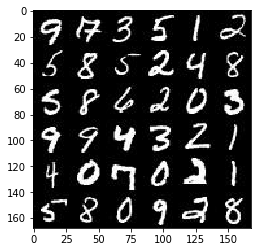

In [3]:
show_n_images = 42

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# !pip install -U matplotlib==2.0.2
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

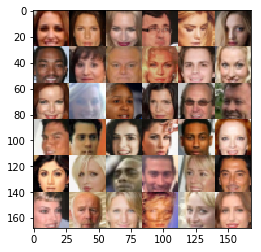

In [4]:
show_n_images = 42

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    real_input = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels), name='real_input')
    z_input = tf.placeholder(dtype=tf.float32,shape=(None, z_dim), name='z_input')
    learning_rate = tf.placeholder(dtype=tf.float32, name='learning_rate')

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    dropout = 0.6
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)

        flat = tf.reshape(x3, (-1, 4*4*256))
        dropout_layer = tf.layers.dropout(inputs=flat, rate=dropout)
        logits = tf.layers.dense(dropout_layer, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [14]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse= not is_train):
        x1 = tf.layers.dense(z, 3*3*512, use_bias=False, activation=None)
        x1 = tf.reshape(x1, (-1, 3, 3, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, kernel_size=4, strides=2, padding='same', use_bias=False, activation=None)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
   
        x3 = tf.layers.conv2d_transpose(x2, 128, kernel_size=4, strides=2, padding='valid', use_bias=False, activation=None)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, kernel_size=5,strides=2, padding='same', activation=None)
        out = tf.tanh(logits)
        
    return out
    



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [17]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [18]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [36]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print_every = 10
    show_every = 100
    images_to_show = 10
    losses =[]
    steps = 0
    _, width, height, channels = data_shape
    
    real_input, z_input, lr = model_inputs(width, height, channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    print("Trainning start ...")
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # Get images, reshape and rescale to pass to D
                batch_images = batch_images*2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={real_input: batch_images, z_input: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={z_input: batch_z, real_input: batch_images, lr: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({z_input: batch_z, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: batch_z})

                    print("Step: {}:".format(steps),
                          "Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, images_to_show, z_input, channels, data_image_mode)
                    
    print("Training done!")


                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Trainning start ...
Step: 10: Epoch 1/2... Discriminator Loss: 1.0935... Generator Loss: 0.9707
Step: 20: Epoch 1/2... Discriminator Loss: 1.8814... Generator Loss: 4.9462
Step: 30: Epoch 1/2... Discriminator Loss: 1.2593... Generator Loss: 0.7832
Step: 40: Epoch 1/2... Discriminator Loss: 2.0936... Generator Loss: 0.2166
Step: 50: Epoch 1/2... Discriminator Loss: 1.2215... Generator Loss: 1.7161
Step: 60: Epoch 1/2... Discriminator Loss: 1.7611... Generator Loss: 2.3638
Step: 70: Epoch 1/2... Discriminator Loss: 1.9153... Generator Loss: 2.8008
Step: 80: Epoch 1/2... Discriminator Loss: 1.2887... Generator Loss: 1.4463
Step: 90: Epoch 1/2... Discriminator Loss: 1.7105... Generator Loss: 2.0303
Step: 100: Epoch 1/2... Discriminator Loss: 1.5059... Generator Loss: 1.3539


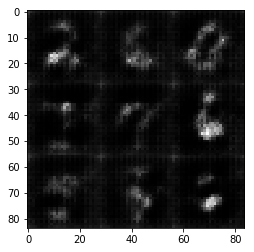

Step: 110: Epoch 1/2... Discriminator Loss: 1.4619... Generator Loss: 1.8547
Step: 120: Epoch 1/2... Discriminator Loss: 1.4732... Generator Loss: 1.3790
Step: 130: Epoch 1/2... Discriminator Loss: 1.2411... Generator Loss: 0.9618
Step: 140: Epoch 1/2... Discriminator Loss: 1.7464... Generator Loss: 0.3389
Step: 150: Epoch 1/2... Discriminator Loss: 1.5324... Generator Loss: 0.4441
Step: 160: Epoch 1/2... Discriminator Loss: 1.3305... Generator Loss: 0.5899
Step: 170: Epoch 1/2... Discriminator Loss: 1.6683... Generator Loss: 0.3502
Step: 180: Epoch 1/2... Discriminator Loss: 1.3907... Generator Loss: 0.5842
Step: 190: Epoch 1/2... Discriminator Loss: 1.3723... Generator Loss: 0.5372
Step: 200: Epoch 1/2... Discriminator Loss: 1.4427... Generator Loss: 0.5206


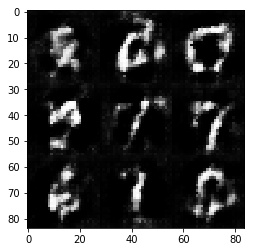

Step: 210: Epoch 1/2... Discriminator Loss: 1.5545... Generator Loss: 0.4037
Step: 220: Epoch 1/2... Discriminator Loss: 1.6072... Generator Loss: 0.3823
Step: 230: Epoch 1/2... Discriminator Loss: 1.2927... Generator Loss: 0.5763
Step: 240: Epoch 1/2... Discriminator Loss: 1.6303... Generator Loss: 0.3621
Step: 250: Epoch 1/2... Discriminator Loss: 1.4645... Generator Loss: 0.4884
Step: 260: Epoch 1/2... Discriminator Loss: 1.6073... Generator Loss: 0.4037
Step: 270: Epoch 1/2... Discriminator Loss: 1.7107... Generator Loss: 0.3471
Step: 280: Epoch 1/2... Discriminator Loss: 1.2507... Generator Loss: 0.6889
Step: 290: Epoch 1/2... Discriminator Loss: 1.5400... Generator Loss: 0.4240
Step: 300: Epoch 1/2... Discriminator Loss: 1.6181... Generator Loss: 0.3864


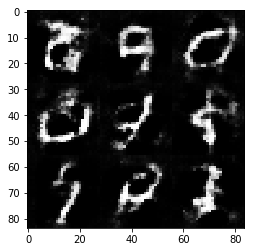

Step: 310: Epoch 1/2... Discriminator Loss: 1.4981... Generator Loss: 0.4228
Step: 320: Epoch 1/2... Discriminator Loss: 1.3051... Generator Loss: 0.6370
Step: 330: Epoch 1/2... Discriminator Loss: 1.4582... Generator Loss: 0.4927
Step: 340: Epoch 1/2... Discriminator Loss: 1.3410... Generator Loss: 0.6006
Step: 350: Epoch 1/2... Discriminator Loss: 1.3624... Generator Loss: 0.5198
Step: 360: Epoch 1/2... Discriminator Loss: 1.3674... Generator Loss: 0.6081
Step: 370: Epoch 1/2... Discriminator Loss: 1.4756... Generator Loss: 0.4498
Step: 380: Epoch 1/2... Discriminator Loss: 1.3637... Generator Loss: 0.5843
Step: 390: Epoch 1/2... Discriminator Loss: 1.4906... Generator Loss: 0.4668
Step: 400: Epoch 1/2... Discriminator Loss: 1.4050... Generator Loss: 0.5360


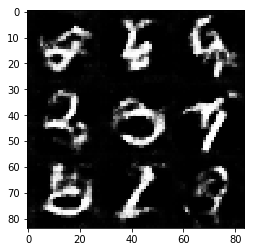

Step: 410: Epoch 1/2... Discriminator Loss: 1.4849... Generator Loss: 0.4473
Step: 420: Epoch 1/2... Discriminator Loss: 1.5290... Generator Loss: 0.4127
Step: 430: Epoch 1/2... Discriminator Loss: 1.4366... Generator Loss: 0.4809
Step: 440: Epoch 1/2... Discriminator Loss: 1.4363... Generator Loss: 0.4778
Step: 450: Epoch 1/2... Discriminator Loss: 1.3564... Generator Loss: 0.5447
Step: 460: Epoch 1/2... Discriminator Loss: 1.3135... Generator Loss: 0.5926
Step: 470: Epoch 1/2... Discriminator Loss: 1.5593... Generator Loss: 0.4015
Step: 480: Epoch 1/2... Discriminator Loss: 1.3923... Generator Loss: 0.5142
Step: 490: Epoch 1/2... Discriminator Loss: 1.4738... Generator Loss: 0.4432
Step: 500: Epoch 1/2... Discriminator Loss: 1.3677... Generator Loss: 0.5248


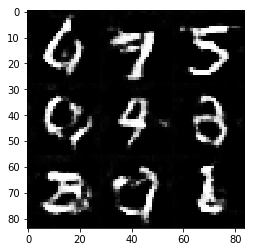

Step: 510: Epoch 1/2... Discriminator Loss: 1.2065... Generator Loss: 0.6820
Step: 520: Epoch 1/2... Discriminator Loss: 1.4472... Generator Loss: 0.5504
Step: 530: Epoch 1/2... Discriminator Loss: 1.5260... Generator Loss: 0.4273
Step: 540: Epoch 1/2... Discriminator Loss: 1.2429... Generator Loss: 0.6554
Step: 550: Epoch 1/2... Discriminator Loss: 2.0461... Generator Loss: 0.2290
Step: 560: Epoch 1/2... Discriminator Loss: 1.4795... Generator Loss: 0.4434
Step: 570: Epoch 1/2... Discriminator Loss: 1.3909... Generator Loss: 0.5019
Step: 580: Epoch 1/2... Discriminator Loss: 1.1401... Generator Loss: 1.3351
Step: 590: Epoch 1/2... Discriminator Loss: 1.3348... Generator Loss: 0.9675
Step: 600: Epoch 1/2... Discriminator Loss: 1.2478... Generator Loss: 1.5066


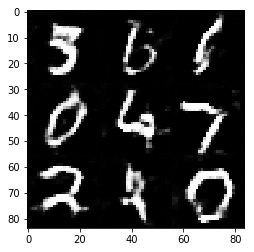

Step: 610: Epoch 1/2... Discriminator Loss: 1.2805... Generator Loss: 1.4733
Step: 620: Epoch 1/2... Discriminator Loss: 1.3147... Generator Loss: 0.5453
Step: 630: Epoch 1/2... Discriminator Loss: 1.2308... Generator Loss: 0.7241
Step: 640: Epoch 1/2... Discriminator Loss: 1.3922... Generator Loss: 0.5234
Step: 650: Epoch 1/2... Discriminator Loss: 1.7321... Generator Loss: 0.3297
Step: 660: Epoch 1/2... Discriminator Loss: 1.7025... Generator Loss: 0.3234
Step: 670: Epoch 1/2... Discriminator Loss: 1.4204... Generator Loss: 0.4945
Step: 680: Epoch 1/2... Discriminator Loss: 1.3101... Generator Loss: 0.5913
Step: 690: Epoch 1/2... Discriminator Loss: 1.5326... Generator Loss: 0.4269
Step: 700: Epoch 1/2... Discriminator Loss: 1.4991... Generator Loss: 0.4481


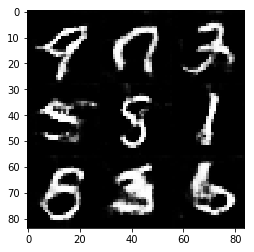

Step: 710: Epoch 1/2... Discriminator Loss: 1.7052... Generator Loss: 0.3366
Step: 720: Epoch 1/2... Discriminator Loss: 1.2786... Generator Loss: 0.5830
Step: 730: Epoch 1/2... Discriminator Loss: 1.5228... Generator Loss: 1.5912
Step: 740: Epoch 1/2... Discriminator Loss: 1.4267... Generator Loss: 1.6749
Step: 750: Epoch 1/2... Discriminator Loss: 1.2600... Generator Loss: 1.3404
Step: 760: Epoch 1/2... Discriminator Loss: 1.1614... Generator Loss: 1.1598
Step: 770: Epoch 1/2... Discriminator Loss: 1.3511... Generator Loss: 0.6382
Step: 780: Epoch 1/2... Discriminator Loss: 1.6794... Generator Loss: 0.3430
Step: 790: Epoch 1/2... Discriminator Loss: 1.2924... Generator Loss: 0.5642
Step: 800: Epoch 1/2... Discriminator Loss: 1.6589... Generator Loss: 0.3613


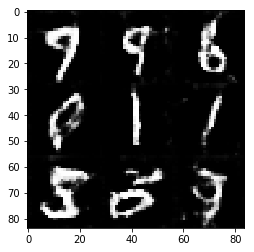

Step: 810: Epoch 1/2... Discriminator Loss: 1.4248... Generator Loss: 0.4828
Step: 820: Epoch 1/2... Discriminator Loss: 1.3435... Generator Loss: 0.5494
Step: 830: Epoch 1/2... Discriminator Loss: 1.3766... Generator Loss: 0.5066
Step: 840: Epoch 1/2... Discriminator Loss: 1.2992... Generator Loss: 0.5935
Step: 850: Epoch 1/2... Discriminator Loss: 1.4499... Generator Loss: 0.4489
Step: 860: Epoch 1/2... Discriminator Loss: 1.2618... Generator Loss: 0.6679
Step: 870: Epoch 1/2... Discriminator Loss: 1.8814... Generator Loss: 0.2931
Step: 880: Epoch 1/2... Discriminator Loss: 1.4206... Generator Loss: 0.5014
Step: 890: Epoch 1/2... Discriminator Loss: 1.7285... Generator Loss: 0.3581
Step: 900: Epoch 1/2... Discriminator Loss: 1.3178... Generator Loss: 1.8805


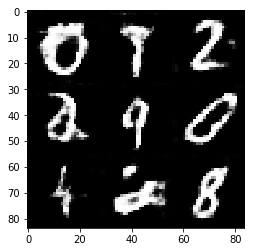

Step: 910: Epoch 1/2... Discriminator Loss: 1.0148... Generator Loss: 1.3185
Step: 920: Epoch 1/2... Discriminator Loss: 1.9042... Generator Loss: 2.2573
Step: 930: Epoch 1/2... Discriminator Loss: 1.3047... Generator Loss: 0.5648
Step: 940: Epoch 2/2... Discriminator Loss: 1.0852... Generator Loss: 1.4561
Step: 950: Epoch 2/2... Discriminator Loss: 1.6326... Generator Loss: 2.1600
Step: 960: Epoch 2/2... Discriminator Loss: 1.1800... Generator Loss: 1.4113
Step: 970: Epoch 2/2... Discriminator Loss: 1.0050... Generator Loss: 1.6403
Step: 980: Epoch 2/2... Discriminator Loss: 1.2560... Generator Loss: 0.7924
Step: 990: Epoch 2/2... Discriminator Loss: 1.2204... Generator Loss: 1.4667
Step: 1000: Epoch 2/2... Discriminator Loss: 1.3049... Generator Loss: 0.5736


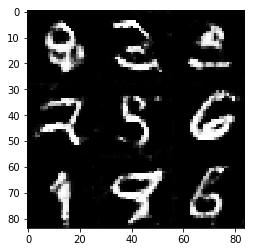

Step: 1010: Epoch 2/2... Discriminator Loss: 1.6457... Generator Loss: 0.3635
Step: 1020: Epoch 2/2... Discriminator Loss: 1.3042... Generator Loss: 0.6285
Step: 1030: Epoch 2/2... Discriminator Loss: 1.0870... Generator Loss: 1.1523
Step: 1040: Epoch 2/2... Discriminator Loss: 1.2589... Generator Loss: 2.0647
Step: 1050: Epoch 2/2... Discriminator Loss: 0.9985... Generator Loss: 1.2053
Step: 1060: Epoch 2/2... Discriminator Loss: 0.9273... Generator Loss: 0.9804
Step: 1070: Epoch 2/2... Discriminator Loss: 1.5925... Generator Loss: 0.3796
Step: 1080: Epoch 2/2... Discriminator Loss: 1.2492... Generator Loss: 1.6596
Step: 1090: Epoch 2/2... Discriminator Loss: 0.8400... Generator Loss: 1.5352
Step: 1100: Epoch 2/2... Discriminator Loss: 1.1035... Generator Loss: 1.0510


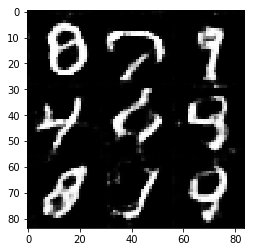

Step: 1110: Epoch 2/2... Discriminator Loss: 1.3641... Generator Loss: 1.8266
Step: 1120: Epoch 2/2... Discriminator Loss: 0.9513... Generator Loss: 1.1112
Step: 1130: Epoch 2/2... Discriminator Loss: 1.3883... Generator Loss: 2.5084
Step: 1140: Epoch 2/2... Discriminator Loss: 0.9922... Generator Loss: 1.6081
Step: 1150: Epoch 2/2... Discriminator Loss: 1.1313... Generator Loss: 0.9559
Step: 1160: Epoch 2/2... Discriminator Loss: 1.1425... Generator Loss: 0.7239
Step: 1170: Epoch 2/2... Discriminator Loss: 1.2676... Generator Loss: 0.6385
Step: 1180: Epoch 2/2... Discriminator Loss: 0.9159... Generator Loss: 1.0495
Step: 1190: Epoch 2/2... Discriminator Loss: 1.9042... Generator Loss: 2.8046
Step: 1200: Epoch 2/2... Discriminator Loss: 2.0146... Generator Loss: 0.2782


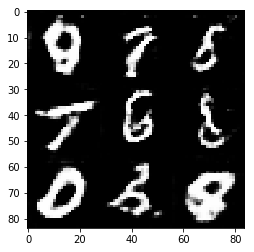

Step: 1210: Epoch 2/2... Discriminator Loss: 1.6694... Generator Loss: 0.3719
Step: 1220: Epoch 2/2... Discriminator Loss: 1.2229... Generator Loss: 0.6352
Step: 1230: Epoch 2/2... Discriminator Loss: 1.3144... Generator Loss: 0.6137
Step: 1240: Epoch 2/2... Discriminator Loss: 1.7430... Generator Loss: 0.3755
Step: 1250: Epoch 2/2... Discriminator Loss: 1.6001... Generator Loss: 0.4700
Step: 1260: Epoch 2/2... Discriminator Loss: 1.1169... Generator Loss: 1.7907
Step: 1270: Epoch 2/2... Discriminator Loss: 1.1874... Generator Loss: 0.9408
Step: 1280: Epoch 2/2... Discriminator Loss: 1.0723... Generator Loss: 1.0939
Step: 1290: Epoch 2/2... Discriminator Loss: 1.5586... Generator Loss: 0.4426
Step: 1300: Epoch 2/2... Discriminator Loss: 1.4480... Generator Loss: 0.5073


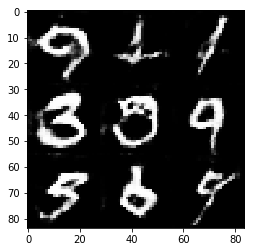

Step: 1310: Epoch 2/2... Discriminator Loss: 1.1958... Generator Loss: 0.7731
Step: 1320: Epoch 2/2... Discriminator Loss: 1.4231... Generator Loss: 0.5275
Step: 1330: Epoch 2/2... Discriminator Loss: 1.2139... Generator Loss: 0.6389
Step: 1340: Epoch 2/2... Discriminator Loss: 1.6761... Generator Loss: 0.3822
Step: 1350: Epoch 2/2... Discriminator Loss: 1.1162... Generator Loss: 0.7565
Step: 1360: Epoch 2/2... Discriminator Loss: 1.3860... Generator Loss: 0.4936
Step: 1370: Epoch 2/2... Discriminator Loss: 1.0498... Generator Loss: 0.7953
Step: 1380: Epoch 2/2... Discriminator Loss: 1.4502... Generator Loss: 2.1531
Step: 1390: Epoch 2/2... Discriminator Loss: 1.1753... Generator Loss: 0.7006
Step: 1400: Epoch 2/2... Discriminator Loss: 1.0678... Generator Loss: 0.8473


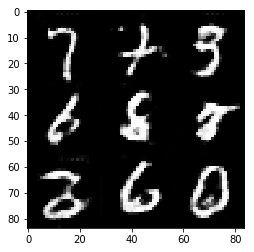

Step: 1410: Epoch 2/2... Discriminator Loss: 0.8568... Generator Loss: 1.8785
Step: 1420: Epoch 2/2... Discriminator Loss: 2.0119... Generator Loss: 3.2651
Step: 1430: Epoch 2/2... Discriminator Loss: 0.9004... Generator Loss: 1.5514
Step: 1440: Epoch 2/2... Discriminator Loss: 1.1459... Generator Loss: 0.8921
Step: 1450: Epoch 2/2... Discriminator Loss: 0.9174... Generator Loss: 1.1495
Step: 1460: Epoch 2/2... Discriminator Loss: 1.7407... Generator Loss: 0.3817
Step: 1470: Epoch 2/2... Discriminator Loss: 0.9382... Generator Loss: 1.6777
Step: 1480: Epoch 2/2... Discriminator Loss: 1.3645... Generator Loss: 0.5334
Step: 1490: Epoch 2/2... Discriminator Loss: 0.9493... Generator Loss: 1.1327
Step: 1500: Epoch 2/2... Discriminator Loss: 1.3228... Generator Loss: 0.6558


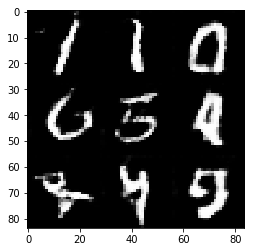

Step: 1510: Epoch 2/2... Discriminator Loss: 1.0397... Generator Loss: 1.8900
Step: 1520: Epoch 2/2... Discriminator Loss: 0.9664... Generator Loss: 1.2244
Step: 1530: Epoch 2/2... Discriminator Loss: 1.0863... Generator Loss: 1.1053
Step: 1540: Epoch 2/2... Discriminator Loss: 1.0917... Generator Loss: 1.3584
Step: 1550: Epoch 2/2... Discriminator Loss: 1.2139... Generator Loss: 0.7076
Step: 1560: Epoch 2/2... Discriminator Loss: 0.7976... Generator Loss: 1.4950
Step: 1570: Epoch 2/2... Discriminator Loss: 0.8704... Generator Loss: 1.6620
Step: 1580: Epoch 2/2... Discriminator Loss: 1.5111... Generator Loss: 2.5329
Step: 1590: Epoch 2/2... Discriminator Loss: 1.0120... Generator Loss: 0.8423
Step: 1600: Epoch 2/2... Discriminator Loss: 1.4995... Generator Loss: 0.4903


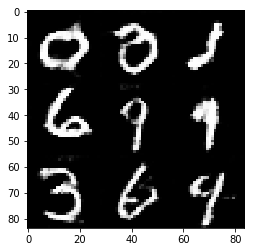

Step: 1610: Epoch 2/2... Discriminator Loss: 1.3832... Generator Loss: 0.5564
Step: 1620: Epoch 2/2... Discriminator Loss: 1.6696... Generator Loss: 2.8332
Step: 1630: Epoch 2/2... Discriminator Loss: 1.1638... Generator Loss: 0.8200
Step: 1640: Epoch 2/2... Discriminator Loss: 0.8303... Generator Loss: 1.1831
Step: 1650: Epoch 2/2... Discriminator Loss: 1.6447... Generator Loss: 2.3417
Step: 1660: Epoch 2/2... Discriminator Loss: 1.2060... Generator Loss: 2.6393
Step: 1670: Epoch 2/2... Discriminator Loss: 1.0576... Generator Loss: 0.9409
Step: 1680: Epoch 2/2... Discriminator Loss: 1.1387... Generator Loss: 0.7034
Step: 1690: Epoch 2/2... Discriminator Loss: 0.8277... Generator Loss: 1.1076
Step: 1700: Epoch 2/2... Discriminator Loss: 1.1447... Generator Loss: 2.8372


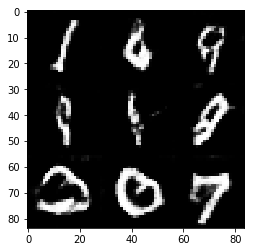

Step: 1710: Epoch 2/2... Discriminator Loss: 1.0049... Generator Loss: 1.6704
Step: 1720: Epoch 2/2... Discriminator Loss: 1.3737... Generator Loss: 2.0893
Step: 1730: Epoch 2/2... Discriminator Loss: 1.2130... Generator Loss: 0.6681
Step: 1740: Epoch 2/2... Discriminator Loss: 0.7880... Generator Loss: 1.6292
Step: 1750: Epoch 2/2... Discriminator Loss: 0.7351... Generator Loss: 1.3956
Step: 1760: Epoch 2/2... Discriminator Loss: 2.1255... Generator Loss: 0.2360
Step: 1770: Epoch 2/2... Discriminator Loss: 1.1529... Generator Loss: 0.7719
Step: 1780: Epoch 2/2... Discriminator Loss: 1.1293... Generator Loss: 0.7929
Step: 1790: Epoch 2/2... Discriminator Loss: 1.4239... Generator Loss: 3.6635
Step: 1800: Epoch 2/2... Discriminator Loss: 1.0611... Generator Loss: 0.8432


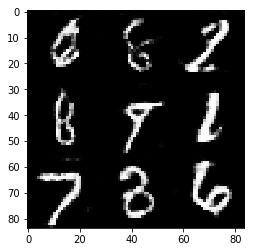

Step: 1810: Epoch 2/2... Discriminator Loss: 1.0573... Generator Loss: 2.2055
Step: 1820: Epoch 2/2... Discriminator Loss: 0.7152... Generator Loss: 1.4450
Step: 1830: Epoch 2/2... Discriminator Loss: 1.0104... Generator Loss: 0.8917
Step: 1840: Epoch 2/2... Discriminator Loss: 1.5769... Generator Loss: 0.5151
Step: 1850: Epoch 2/2... Discriminator Loss: 1.0878... Generator Loss: 2.9763
Step: 1860: Epoch 2/2... Discriminator Loss: 0.9560... Generator Loss: 2.0697
Step: 1870: Epoch 2/2... Discriminator Loss: 1.2676... Generator Loss: 1.8215
Training done!


In [37]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.25


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Trainning start ...
Step: 10: Epoch 1/1... Discriminator Loss: 3.3809... Generator Loss: 0.1507
Step: 20: Epoch 1/1... Discriminator Loss: 1.4856... Generator Loss: 1.2470
Step: 30: Epoch 1/1... Discriminator Loss: 1.6027... Generator Loss: 0.8000
Step: 40: Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 0.8403
Step: 50: Epoch 1/1... Discriminator Loss: 1.2746... Generator Loss: 0.6033
Step: 60: Epoch 1/1... Discriminator Loss: 0.9749... Generator Loss: 1.1543
Step: 70: Epoch 1/1... Discriminator Loss: 1.0429... Generator Loss: 1.4223
Step: 80: Epoch 1/1... Discriminator Loss: 1.5838... Generator Loss: 0.5330
Step: 90: Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 2.0650
Step: 100: Epoch 1/1... Discriminator Loss: 2.0295... Generator Loss: 2.6682


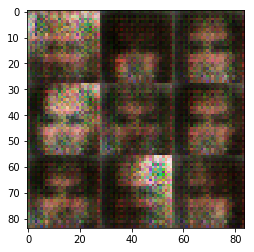

Step: 110: Epoch 1/1... Discriminator Loss: 2.5670... Generator Loss: 3.0657
Step: 120: Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.8835
Step: 130: Epoch 1/1... Discriminator Loss: 1.5711... Generator Loss: 0.7372
Step: 140: Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.8387
Step: 150: Epoch 1/1... Discriminator Loss: 2.0856... Generator Loss: 0.2248
Step: 160: Epoch 1/1... Discriminator Loss: 1.4782... Generator Loss: 0.4922
Step: 170: Epoch 1/1... Discriminator Loss: 1.7056... Generator Loss: 1.1103
Step: 180: Epoch 1/1... Discriminator Loss: 1.6740... Generator Loss: 0.7246
Step: 190: Epoch 1/1... Discriminator Loss: 1.6327... Generator Loss: 0.7470
Step: 200: Epoch 1/1... Discriminator Loss: 1.5295... Generator Loss: 0.7297


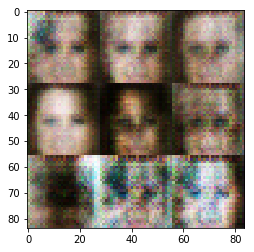

Step: 210: Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.7418
Step: 220: Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.6840
Step: 230: Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.8449
Step: 240: Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.9267
Step: 250: Epoch 1/1... Discriminator Loss: 1.4880... Generator Loss: 0.6717
Step: 260: Epoch 1/1... Discriminator Loss: 1.2966... Generator Loss: 0.8546
Step: 270: Epoch 1/1... Discriminator Loss: 1.4944... Generator Loss: 0.8633
Step: 280: Epoch 1/1... Discriminator Loss: 1.2269... Generator Loss: 0.7996
Step: 290: Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 1.1387
Step: 300: Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.8744


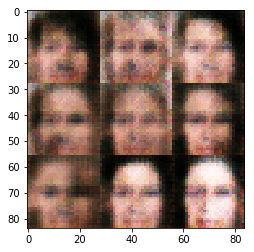

Step: 310: Epoch 1/1... Discriminator Loss: 1.5147... Generator Loss: 1.1441
Step: 320: Epoch 1/1... Discriminator Loss: 1.4773... Generator Loss: 0.6902
Step: 330: Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.7467
Step: 340: Epoch 1/1... Discriminator Loss: 1.5696... Generator Loss: 0.4594
Step: 350: Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.7887
Step: 360: Epoch 1/1... Discriminator Loss: 1.6468... Generator Loss: 0.4679
Step: 370: Epoch 1/1... Discriminator Loss: 1.2460... Generator Loss: 0.7889
Step: 380: Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.5792
Step: 390: Epoch 1/1... Discriminator Loss: 1.0364... Generator Loss: 1.3238
Step: 400: Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.7684


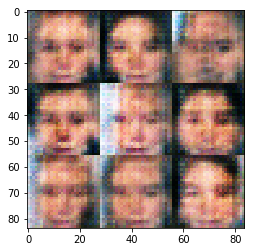

Step: 410: Epoch 1/1... Discriminator Loss: 1.2418... Generator Loss: 0.8844
Step: 420: Epoch 1/1... Discriminator Loss: 1.4571... Generator Loss: 0.8513
Step: 430: Epoch 1/1... Discriminator Loss: 1.2546... Generator Loss: 1.1034
Step: 440: Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 1.0008
Step: 450: Epoch 1/1... Discriminator Loss: 1.6562... Generator Loss: 0.6600
Step: 460: Epoch 1/1... Discriminator Loss: 1.1475... Generator Loss: 0.8342
Step: 470: Epoch 1/1... Discriminator Loss: 1.2568... Generator Loss: 0.9849
Step: 480: Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 1.0928
Step: 490: Epoch 1/1... Discriminator Loss: 1.5195... Generator Loss: 0.4980
Step: 500: Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.7317


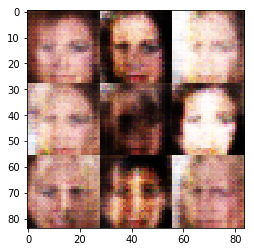

Step: 510: Epoch 1/1... Discriminator Loss: 1.4501... Generator Loss: 0.5985
Step: 520: Epoch 1/1... Discriminator Loss: 1.6804... Generator Loss: 1.5933
Step: 530: Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 0.8211
Step: 540: Epoch 1/1... Discriminator Loss: 1.2484... Generator Loss: 1.0743
Step: 550: Epoch 1/1... Discriminator Loss: 1.4916... Generator Loss: 0.4339
Step: 560: Epoch 1/1... Discriminator Loss: 1.4679... Generator Loss: 0.4599
Step: 570: Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.6729
Step: 580: Epoch 1/1... Discriminator Loss: 1.1261... Generator Loss: 0.7902
Step: 590: Epoch 1/1... Discriminator Loss: 1.3207... Generator Loss: 0.8020
Step: 600: Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.6687


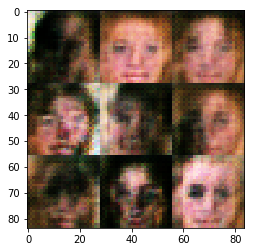

Step: 610: Epoch 1/1... Discriminator Loss: 1.3361... Generator Loss: 1.0272
Step: 620: Epoch 1/1... Discriminator Loss: 1.5166... Generator Loss: 0.7310
Step: 630: Epoch 1/1... Discriminator Loss: 1.2987... Generator Loss: 0.9419
Step: 640: Epoch 1/1... Discriminator Loss: 1.2720... Generator Loss: 0.7915
Step: 650: Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 1.6532
Step: 660: Epoch 1/1... Discriminator Loss: 1.2197... Generator Loss: 0.8804
Step: 670: Epoch 1/1... Discriminator Loss: 1.2251... Generator Loss: 0.8479
Step: 680: Epoch 1/1... Discriminator Loss: 1.5768... Generator Loss: 0.6023
Step: 690: Epoch 1/1... Discriminator Loss: 1.0444... Generator Loss: 1.0024
Step: 700: Epoch 1/1... Discriminator Loss: 1.7094... Generator Loss: 0.4815


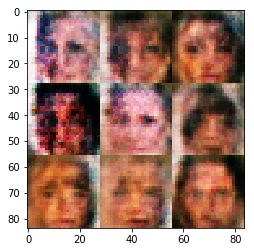

Step: 710: Epoch 1/1... Discriminator Loss: 1.2844... Generator Loss: 0.7956
Step: 720: Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.9933
Step: 730: Epoch 1/1... Discriminator Loss: 1.3207... Generator Loss: 0.6937
Step: 740: Epoch 1/1... Discriminator Loss: 1.4769... Generator Loss: 0.6708
Step: 750: Epoch 1/1... Discriminator Loss: 1.9531... Generator Loss: 0.3147
Step: 760: Epoch 1/1... Discriminator Loss: 1.3346... Generator Loss: 0.9578
Step: 770: Epoch 1/1... Discriminator Loss: 1.7879... Generator Loss: 0.4069
Step: 780: Epoch 1/1... Discriminator Loss: 1.2666... Generator Loss: 0.8553
Step: 790: Epoch 1/1... Discriminator Loss: 1.5888... Generator Loss: 0.8235
Step: 800: Epoch 1/1... Discriminator Loss: 1.4787... Generator Loss: 0.5640


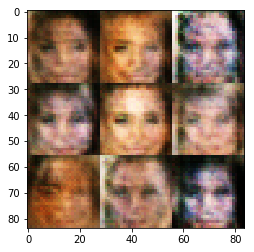

Step: 810: Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 1.2404
Step: 820: Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 1.2218
Step: 830: Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 1.4735
Step: 840: Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.6985
Step: 850: Epoch 1/1... Discriminator Loss: 1.5444... Generator Loss: 0.5395
Step: 860: Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.7607
Step: 870: Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.6845
Step: 880: Epoch 1/1... Discriminator Loss: 1.2941... Generator Loss: 0.8218
Step: 890: Epoch 1/1... Discriminator Loss: 1.5963... Generator Loss: 1.0461
Step: 900: Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 0.9745


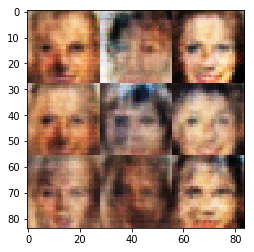

Step: 910: Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.9795
Step: 920: Epoch 1/1... Discriminator Loss: 1.2834... Generator Loss: 0.9767
Step: 930: Epoch 1/1... Discriminator Loss: 1.6274... Generator Loss: 1.6520
Step: 940: Epoch 1/1... Discriminator Loss: 1.2939... Generator Loss: 0.7319
Step: 950: Epoch 1/1... Discriminator Loss: 1.2693... Generator Loss: 1.1995
Step: 960: Epoch 1/1... Discriminator Loss: 1.2650... Generator Loss: 0.8755
Step: 970: Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 0.9420
Step: 980: Epoch 1/1... Discriminator Loss: 1.2162... Generator Loss: 0.7839
Step: 990: Epoch 1/1... Discriminator Loss: 1.3167... Generator Loss: 0.9162
Step: 1000: Epoch 1/1... Discriminator Loss: 1.5249... Generator Loss: 0.5830


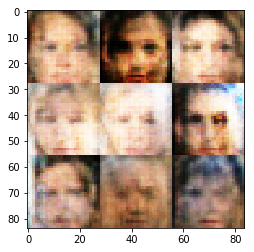

Step: 1010: Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.7474
Step: 1020: Epoch 1/1... Discriminator Loss: 1.4923... Generator Loss: 0.7145
Step: 1030: Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.7954
Step: 1040: Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.6598
Step: 1050: Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.6903
Step: 1060: Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.9724
Step: 1070: Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 0.8164
Step: 1080: Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.7481
Step: 1090: Epoch 1/1... Discriminator Loss: 1.2681... Generator Loss: 0.8597
Step: 1100: Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.8593


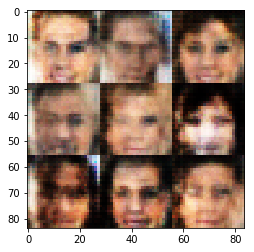

Step: 1110: Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 0.6386
Step: 1120: Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 1.2127
Step: 1130: Epoch 1/1... Discriminator Loss: 1.2585... Generator Loss: 0.6189
Step: 1140: Epoch 1/1... Discriminator Loss: 1.1247... Generator Loss: 0.9665
Step: 1150: Epoch 1/1... Discriminator Loss: 1.5397... Generator Loss: 0.5754
Step: 1160: Epoch 1/1... Discriminator Loss: 1.2713... Generator Loss: 0.7257
Step: 1170: Epoch 1/1... Discriminator Loss: 1.6128... Generator Loss: 0.6292
Step: 1180: Epoch 1/1... Discriminator Loss: 1.4619... Generator Loss: 0.7273
Step: 1190: Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.7574
Step: 1200: Epoch 1/1... Discriminator Loss: 1.1599... Generator Loss: 0.7968


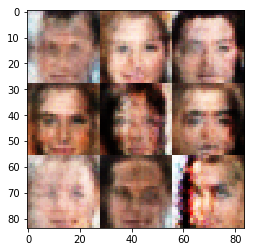

Step: 1210: Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 1.0762
Step: 1220: Epoch 1/1... Discriminator Loss: 1.5811... Generator Loss: 0.5992
Step: 1230: Epoch 1/1... Discriminator Loss: 1.5488... Generator Loss: 1.3747
Step: 1240: Epoch 1/1... Discriminator Loss: 1.4698... Generator Loss: 0.6026
Step: 1250: Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 0.9437
Step: 1260: Epoch 1/1... Discriminator Loss: 1.4822... Generator Loss: 0.6083
Step: 1270: Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.7479
Step: 1280: Epoch 1/1... Discriminator Loss: 1.3211... Generator Loss: 0.8518
Step: 1290: Epoch 1/1... Discriminator Loss: 1.5183... Generator Loss: 0.4828
Step: 1300: Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 0.9445


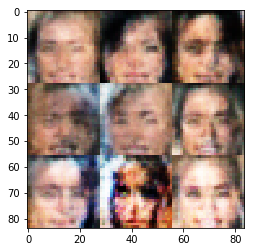

Step: 1310: Epoch 1/1... Discriminator Loss: 1.2100... Generator Loss: 1.0919
Step: 1320: Epoch 1/1... Discriminator Loss: 1.1804... Generator Loss: 0.8635
Step: 1330: Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 1.2578
Step: 1340: Epoch 1/1... Discriminator Loss: 1.3441... Generator Loss: 0.9876
Step: 1350: Epoch 1/1... Discriminator Loss: 1.2827... Generator Loss: 1.0000
Step: 1360: Epoch 1/1... Discriminator Loss: 1.2528... Generator Loss: 0.9116
Step: 1370: Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.8171
Step: 1380: Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 0.7187
Step: 1390: Epoch 1/1... Discriminator Loss: 1.6369... Generator Loss: 0.3699
Step: 1400: Epoch 1/1... Discriminator Loss: 1.3436... Generator Loss: 0.9093


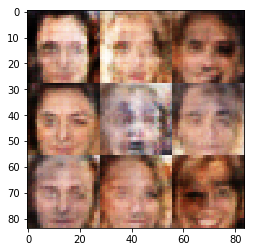

Step: 1410: Epoch 1/1... Discriminator Loss: 1.5723... Generator Loss: 0.4144
Step: 1420: Epoch 1/1... Discriminator Loss: 1.7188... Generator Loss: 1.5446
Step: 1430: Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.7530
Step: 1440: Epoch 1/1... Discriminator Loss: 1.6894... Generator Loss: 1.6137
Step: 1450: Epoch 1/1... Discriminator Loss: 1.5235... Generator Loss: 1.0276
Step: 1460: Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.4822
Step: 1470: Epoch 1/1... Discriminator Loss: 1.2663... Generator Loss: 0.8682
Step: 1480: Epoch 1/1... Discriminator Loss: 1.1423... Generator Loss: 0.7531
Step: 1490: Epoch 1/1... Discriminator Loss: 1.3167... Generator Loss: 0.8107
Step: 1500: Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.7594


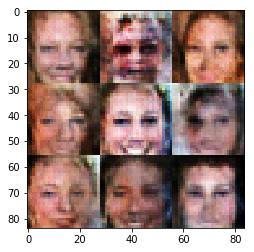

Step: 1510: Epoch 1/1... Discriminator Loss: 1.2536... Generator Loss: 0.7901
Step: 1520: Epoch 1/1... Discriminator Loss: 1.2033... Generator Loss: 1.0831
Step: 1530: Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 0.7028
Step: 1540: Epoch 1/1... Discriminator Loss: 1.1602... Generator Loss: 1.0325
Step: 1550: Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.5478
Step: 1560: Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 1.0236
Step: 1570: Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.7224
Step: 1580: Epoch 1/1... Discriminator Loss: 1.2391... Generator Loss: 1.0514
Step: 1590: Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.8556
Step: 1600: Epoch 1/1... Discriminator Loss: 1.2272... Generator Loss: 0.8103


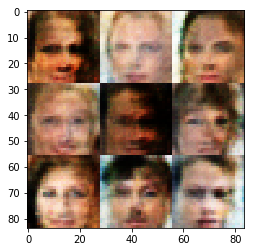

Step: 1610: Epoch 1/1... Discriminator Loss: 1.4410... Generator Loss: 0.5570
Step: 1620: Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 1.1485
Step: 1630: Epoch 1/1... Discriminator Loss: 1.3294... Generator Loss: 0.7096
Step: 1640: Epoch 1/1... Discriminator Loss: 1.2595... Generator Loss: 0.8024
Step: 1650: Epoch 1/1... Discriminator Loss: 1.2924... Generator Loss: 0.9017
Step: 1660: Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.8171
Step: 1670: Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 0.8428
Step: 1680: Epoch 1/1... Discriminator Loss: 1.4798... Generator Loss: 0.6550
Step: 1690: Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 1.0511
Step: 1700: Epoch 1/1... Discriminator Loss: 1.2587... Generator Loss: 0.8441


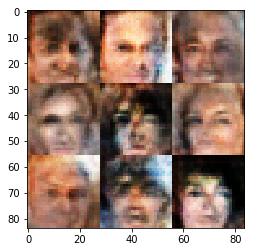

Step: 1710: Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.6155
Step: 1720: Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 0.8499
Step: 1730: Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 0.6338
Step: 1740: Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.9754
Step: 1750: Epoch 1/1... Discriminator Loss: 1.2568... Generator Loss: 0.7995
Step: 1760: Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.6165
Step: 1770: Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.7183
Step: 1780: Epoch 1/1... Discriminator Loss: 1.3021... Generator Loss: 0.6465
Step: 1790: Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 0.8040
Step: 1800: Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 1.0084


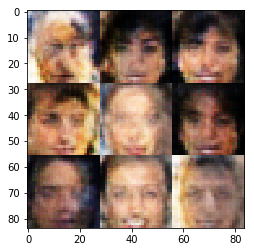

Step: 1810: Epoch 1/1... Discriminator Loss: 1.5263... Generator Loss: 0.6719
Step: 1820: Epoch 1/1... Discriminator Loss: 1.0674... Generator Loss: 1.0068
Step: 1830: Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 0.8196
Step: 1840: Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.8471
Step: 1850: Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 1.2965
Step: 1860: Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.6841
Step: 1870: Epoch 1/1... Discriminator Loss: 1.3474... Generator Loss: 1.0909
Step: 1880: Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.6529
Step: 1890: Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 0.8517
Step: 1900: Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.6870


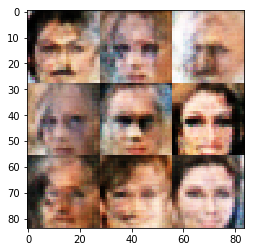

Step: 1910: Epoch 1/1... Discriminator Loss: 1.2863... Generator Loss: 0.6502
Step: 1920: Epoch 1/1... Discriminator Loss: 1.5563... Generator Loss: 0.4025
Step: 1930: Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.7151
Step: 1940: Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 0.6304
Step: 1950: Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 0.9388
Step: 1960: Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.8377
Step: 1970: Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.6932
Step: 1980: Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 1.2892
Step: 1990: Epoch 1/1... Discriminator Loss: 1.2005... Generator Loss: 0.8494
Step: 2000: Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.4873


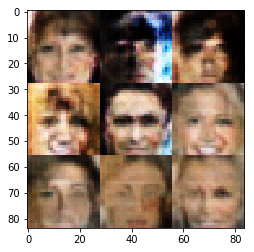

Step: 2010: Epoch 1/1... Discriminator Loss: 1.4498... Generator Loss: 0.5417
Step: 2020: Epoch 1/1... Discriminator Loss: 1.4633... Generator Loss: 0.6813
Step: 2030: Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 0.7032
Step: 2040: Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.6856
Step: 2050: Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.5488
Step: 2060: Epoch 1/1... Discriminator Loss: 1.2599... Generator Loss: 0.7394
Step: 2070: Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.5678
Step: 2080: Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.6844
Step: 2090: Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.6492
Step: 2100: Epoch 1/1... Discriminator Loss: 1.5482... Generator Loss: 0.5267


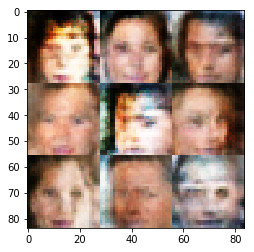

Step: 2110: Epoch 1/1... Discriminator Loss: 1.6885... Generator Loss: 0.3326
Step: 2120: Epoch 1/1... Discriminator Loss: 1.1560... Generator Loss: 1.0375
Step: 2130: Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.5745
Step: 2140: Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 0.9999
Step: 2150: Epoch 1/1... Discriminator Loss: 1.6352... Generator Loss: 0.3829
Step: 2160: Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.8182
Step: 2170: Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 0.8078
Step: 2180: Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 1.1114
Step: 2190: Epoch 1/1... Discriminator Loss: 1.3074... Generator Loss: 0.7797
Step: 2200: Epoch 1/1... Discriminator Loss: 1.2783... Generator Loss: 0.7327


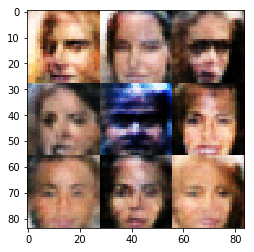

Step: 2210: Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.5790
Step: 2220: Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.9078
Step: 2230: Epoch 1/1... Discriminator Loss: 1.5467... Generator Loss: 1.6052
Step: 2240: Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.5882
Step: 2250: Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 0.9442
Step: 2260: Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.5839
Step: 2270: Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 1.4613
Step: 2280: Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.8823
Step: 2290: Epoch 1/1... Discriminator Loss: 1.2792... Generator Loss: 0.9081
Step: 2300: Epoch 1/1... Discriminator Loss: 1.2686... Generator Loss: 0.7299


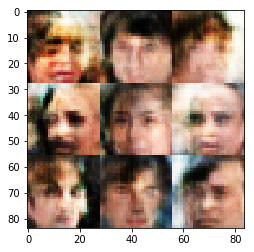

Step: 2310: Epoch 1/1... Discriminator Loss: 1.2776... Generator Loss: 1.0123
Step: 2320: Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.6750
Step: 2330: Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 1.2538
Step: 2340: Epoch 1/1... Discriminator Loss: 1.3150... Generator Loss: 0.9620
Step: 2350: Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 0.8853
Step: 2360: Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.5101
Step: 2370: Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.7084
Step: 2380: Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.7139
Step: 2390: Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.5113
Step: 2400: Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 1.1361


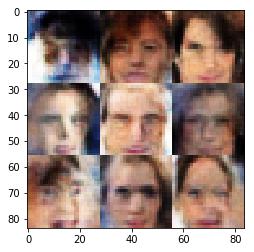

Step: 2410: Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 0.5033
Step: 2420: Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 0.8766
Step: 2430: Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 1.0057
Step: 2440: Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.7654
Step: 2450: Epoch 1/1... Discriminator Loss: 1.2456... Generator Loss: 0.7990
Step: 2460: Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 0.6065
Step: 2470: Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 1.3038
Step: 2480: Epoch 1/1... Discriminator Loss: 1.2155... Generator Loss: 0.6580
Step: 2490: Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.6321
Step: 2500: Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 0.7959


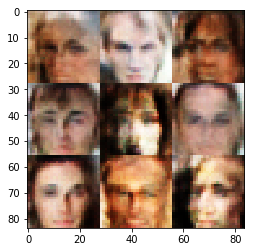

Step: 2510: Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.5294
Step: 2520: Epoch 1/1... Discriminator Loss: 1.5504... Generator Loss: 1.4051
Step: 2530: Epoch 1/1... Discriminator Loss: 1.5528... Generator Loss: 1.2355
Step: 2540: Epoch 1/1... Discriminator Loss: 1.5091... Generator Loss: 0.5129
Step: 2550: Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.6299
Step: 2560: Epoch 1/1... Discriminator Loss: 1.2581... Generator Loss: 0.7260
Step: 2570: Epoch 1/1... Discriminator Loss: 1.3262... Generator Loss: 0.7297
Step: 2580: Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.7002
Step: 2590: Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.7185
Step: 2600: Epoch 1/1... Discriminator Loss: 1.3124... Generator Loss: 0.7242


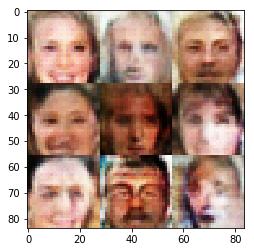

Step: 2610: Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 0.7021
Step: 2620: Epoch 1/1... Discriminator Loss: 1.6133... Generator Loss: 0.3726
Step: 2630: Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 0.8839
Step: 2640: Epoch 1/1... Discriminator Loss: 1.2709... Generator Loss: 0.7591
Step: 2650: Epoch 1/1... Discriminator Loss: 1.2721... Generator Loss: 0.8245
Step: 2660: Epoch 1/1... Discriminator Loss: 1.1976... Generator Loss: 1.0966
Step: 2670: Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 0.7602
Step: 2680: Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.6056
Step: 2690: Epoch 1/1... Discriminator Loss: 1.5731... Generator Loss: 0.3957
Step: 2700: Epoch 1/1... Discriminator Loss: 1.4994... Generator Loss: 0.4814


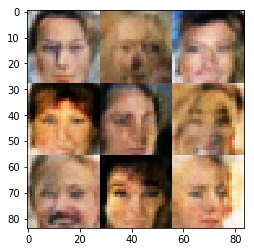

Step: 2710: Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.5769
Step: 2720: Epoch 1/1... Discriminator Loss: 1.1713... Generator Loss: 0.9835
Step: 2730: Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.6005
Step: 2740: Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.9026
Step: 2750: Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 1.1217
Step: 2760: Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.5184
Step: 2770: Epoch 1/1... Discriminator Loss: 1.5094... Generator Loss: 0.4278
Step: 2780: Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 0.9265
Step: 2790: Epoch 1/1... Discriminator Loss: 1.4598... Generator Loss: 1.1656
Step: 2800: Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.6767


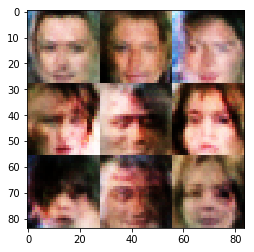

Step: 2810: Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.6203
Step: 2820: Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 1.0497
Step: 2830: Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.7126
Step: 2840: Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.5553
Step: 2850: Epoch 1/1... Discriminator Loss: 1.3264... Generator Loss: 0.8461
Step: 2860: Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 0.8656
Step: 2870: Epoch 1/1... Discriminator Loss: 1.1710... Generator Loss: 0.8619
Step: 2880: Epoch 1/1... Discriminator Loss: 1.1944... Generator Loss: 0.7329
Step: 2890: Epoch 1/1... Discriminator Loss: 1.2607... Generator Loss: 0.5925
Step: 2900: Epoch 1/1... Discriminator Loss: 1.4992... Generator Loss: 0.4994


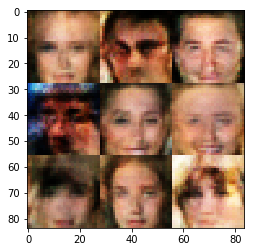

Step: 2910: Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.7645
Step: 2920: Epoch 1/1... Discriminator Loss: 1.9588... Generator Loss: 1.3377
Step: 2930: Epoch 1/1... Discriminator Loss: 1.2233... Generator Loss: 0.9598
Step: 2940: Epoch 1/1... Discriminator Loss: 1.5654... Generator Loss: 0.6442
Step: 2950: Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.7027
Step: 2960: Epoch 1/1... Discriminator Loss: 1.1981... Generator Loss: 1.1371
Step: 2970: Epoch 1/1... Discriminator Loss: 1.0837... Generator Loss: 1.2948
Step: 2980: Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 0.8987
Step: 2990: Epoch 1/1... Discriminator Loss: 1.4752... Generator Loss: 0.5447
Step: 3000: Epoch 1/1... Discriminator Loss: 1.2699... Generator Loss: 0.7336


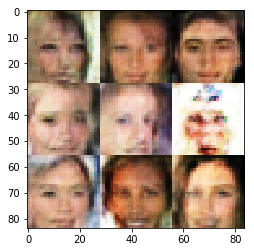

Step: 3010: Epoch 1/1... Discriminator Loss: 1.5261... Generator Loss: 0.4345
Step: 3020: Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.6171
Step: 3030: Epoch 1/1... Discriminator Loss: 1.1585... Generator Loss: 0.8432
Step: 3040: Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.5496
Step: 3050: Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.5215
Step: 3060: Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.7601
Step: 3070: Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.5383
Step: 3080: Epoch 1/1... Discriminator Loss: 1.2944... Generator Loss: 0.7223
Step: 3090: Epoch 1/1... Discriminator Loss: 1.4924... Generator Loss: 0.4445
Step: 3100: Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.6599


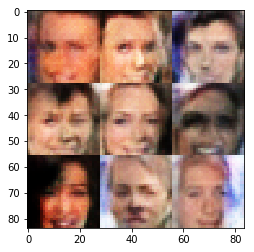

Step: 3110: Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.5028
Step: 3120: Epoch 1/1... Discriminator Loss: 1.1727... Generator Loss: 0.7723
Step: 3130: Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 0.6423
Step: 3140: Epoch 1/1... Discriminator Loss: 1.4570... Generator Loss: 0.5160
Step: 3150: Epoch 1/1... Discriminator Loss: 1.1051... Generator Loss: 0.9354
Step: 3160: Epoch 1/1... Discriminator Loss: 1.3140... Generator Loss: 0.7524
Step: 3170: Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 0.9212
Step: 3180: Epoch 1/1... Discriminator Loss: 1.2364... Generator Loss: 0.9466
Step: 3190: Epoch 1/1... Discriminator Loss: 1.2436... Generator Loss: 0.7299
Step: 3200: Epoch 1/1... Discriminator Loss: 1.2900... Generator Loss: 0.6361


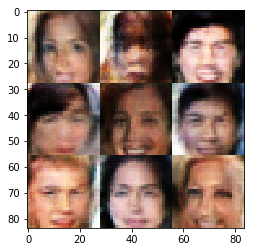

Step: 3210: Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 0.7199
Step: 3220: Epoch 1/1... Discriminator Loss: 1.2286... Generator Loss: 0.8744
Step: 3230: Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.7363
Step: 3240: Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 0.9000
Step: 3250: Epoch 1/1... Discriminator Loss: 1.3140... Generator Loss: 1.0206
Step: 3260: Epoch 1/1... Discriminator Loss: 1.6058... Generator Loss: 0.4024
Step: 3270: Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.6888
Step: 3280: Epoch 1/1... Discriminator Loss: 1.2270... Generator Loss: 0.6876
Step: 3290: Epoch 1/1... Discriminator Loss: 1.1619... Generator Loss: 1.3925
Step: 3300: Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.5915


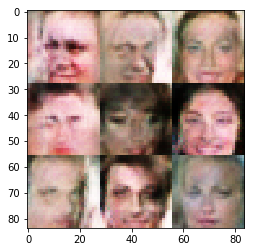

Step: 3310: Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.6335
Step: 3320: Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 0.8076
Step: 3330: Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 0.8472
Step: 3340: Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.6805
Step: 3350: Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 1.0033
Step: 3360: Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.8571
Step: 3370: Epoch 1/1... Discriminator Loss: 1.3207... Generator Loss: 0.9192
Step: 3380: Epoch 1/1... Discriminator Loss: 1.5076... Generator Loss: 0.4405
Step: 3390: Epoch 1/1... Discriminator Loss: 1.2080... Generator Loss: 0.8278
Step: 3400: Epoch 1/1... Discriminator Loss: 1.1317... Generator Loss: 1.0073


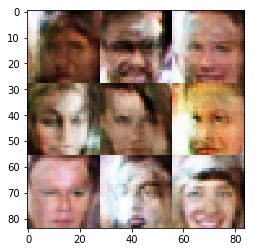

Step: 3410: Epoch 1/1... Discriminator Loss: 1.1420... Generator Loss: 0.8740
Step: 3420: Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 0.9009
Step: 3430: Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.6432
Step: 3440: Epoch 1/1... Discriminator Loss: 1.2896... Generator Loss: 0.8742
Step: 3450: Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.5231
Step: 3460: Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.8986
Step: 3470: Epoch 1/1... Discriminator Loss: 1.6333... Generator Loss: 0.3725
Step: 3480: Epoch 1/1... Discriminator Loss: 1.2295... Generator Loss: 0.7675
Step: 3490: Epoch 1/1... Discriminator Loss: 1.3139... Generator Loss: 0.6180
Step: 3500: Epoch 1/1... Discriminator Loss: 1.2051... Generator Loss: 1.3154


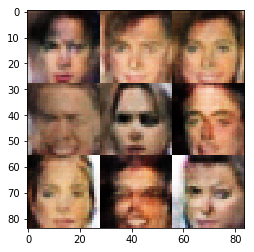

Step: 3510: Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.5563
Step: 3520: Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 0.9190
Step: 3530: Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 1.0371
Step: 3540: Epoch 1/1... Discriminator Loss: 1.2719... Generator Loss: 1.1756
Step: 3550: Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.5896
Step: 3560: Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 0.8880
Step: 3570: Epoch 1/1... Discriminator Loss: 1.3087... Generator Loss: 0.8070
Step: 3580: Epoch 1/1... Discriminator Loss: 1.2102... Generator Loss: 0.8289
Step: 3590: Epoch 1/1... Discriminator Loss: 1.3043... Generator Loss: 0.8867
Step: 3600: Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 0.7979


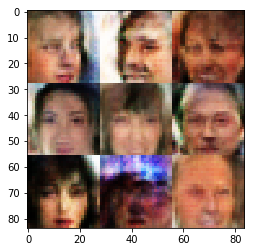

Step: 3610: Epoch 1/1... Discriminator Loss: 1.2016... Generator Loss: 0.7610
Step: 3620: Epoch 1/1... Discriminator Loss: 1.7376... Generator Loss: 0.4174
Step: 3630: Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 0.7922
Step: 3640: Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.5534
Step: 3650: Epoch 1/1... Discriminator Loss: 1.2285... Generator Loss: 0.8541
Step: 3660: Epoch 1/1... Discriminator Loss: 1.6052... Generator Loss: 0.4116
Step: 3670: Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 0.7076
Step: 3680: Epoch 1/1... Discriminator Loss: 1.2788... Generator Loss: 0.7071
Step: 3690: Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.5874
Step: 3700: Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.5878


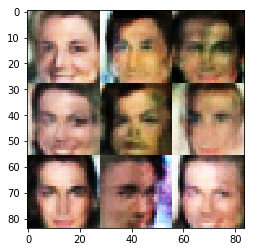

Step: 3710: Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.5411
Step: 3720: Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 1.2809
Step: 3730: Epoch 1/1... Discriminator Loss: 1.1299... Generator Loss: 1.2565
Step: 3740: Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.6569
Step: 3750: Epoch 1/1... Discriminator Loss: 1.2879... Generator Loss: 1.2560
Step: 3760: Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 1.7836
Step: 3770: Epoch 1/1... Discriminator Loss: 1.0838... Generator Loss: 0.8940
Step: 3780: Epoch 1/1... Discriminator Loss: 1.2643... Generator Loss: 1.4887
Step: 3790: Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.5657
Step: 3800: Epoch 1/1... Discriminator Loss: 1.5758... Generator Loss: 0.4567


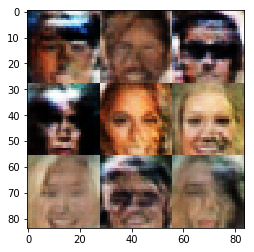

Step: 3810: Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.9381
Step: 3820: Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 0.6945
Step: 3830: Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.9570
Step: 3840: Epoch 1/1... Discriminator Loss: 1.2514... Generator Loss: 0.8881
Step: 3850: Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.9640
Step: 3860: Epoch 1/1... Discriminator Loss: 1.3049... Generator Loss: 0.7648
Step: 3870: Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 0.8892
Step: 3880: Epoch 1/1... Discriminator Loss: 1.2948... Generator Loss: 0.7463
Step: 3890: Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.7195
Step: 3900: Epoch 1/1... Discriminator Loss: 1.3019... Generator Loss: 0.8249


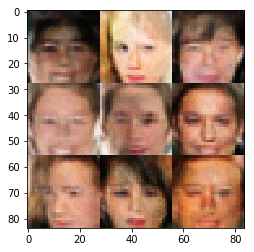

Step: 3910: Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.7723
Step: 3920: Epoch 1/1... Discriminator Loss: 1.1677... Generator Loss: 1.4090
Step: 3930: Epoch 1/1... Discriminator Loss: 1.2042... Generator Loss: 1.1671
Step: 3940: Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 0.6556
Step: 3950: Epoch 1/1... Discriminator Loss: 1.2641... Generator Loss: 0.7607
Step: 3960: Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 0.6954
Step: 3970: Epoch 1/1... Discriminator Loss: 1.5490... Generator Loss: 0.4717
Step: 3980: Epoch 1/1... Discriminator Loss: 1.4914... Generator Loss: 0.6744
Step: 3990: Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.4628
Step: 4000: Epoch 1/1... Discriminator Loss: 1.2851... Generator Loss: 0.6001


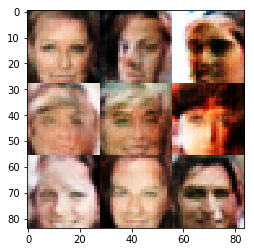

Step: 4010: Epoch 1/1... Discriminator Loss: 1.6610... Generator Loss: 0.4134
Step: 4020: Epoch 1/1... Discriminator Loss: 1.1304... Generator Loss: 0.7959
Step: 4030: Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.8510
Step: 4040: Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.8176
Step: 4050: Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.7557
Step: 4060: Epoch 1/1... Discriminator Loss: 1.3517... Generator Loss: 0.6590
Step: 4070: Epoch 1/1... Discriminator Loss: 1.2086... Generator Loss: 0.7951
Step: 4080: Epoch 1/1... Discriminator Loss: 1.2377... Generator Loss: 0.8155
Step: 4090: Epoch 1/1... Discriminator Loss: 1.6015... Generator Loss: 0.4467
Step: 4100: Epoch 1/1... Discriminator Loss: 1.2336... Generator Loss: 0.7056


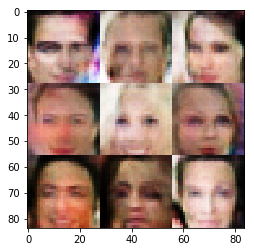

Step: 4110: Epoch 1/1... Discriminator Loss: 1.2856... Generator Loss: 0.7654
Step: 4120: Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.6196
Step: 4130: Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.6506
Step: 4140: Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.9324
Step: 4150: Epoch 1/1... Discriminator Loss: 1.6173... Generator Loss: 0.3656
Step: 4160: Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.5768
Step: 4170: Epoch 1/1... Discriminator Loss: 1.5233... Generator Loss: 0.4216
Step: 4180: Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.6803
Step: 4190: Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.6651
Step: 4200: Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.7103


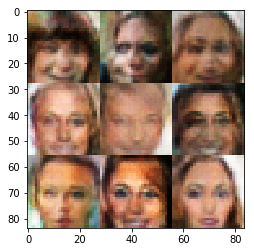

Step: 4210: Epoch 1/1... Discriminator Loss: 1.1719... Generator Loss: 0.8073
Step: 4220: Epoch 1/1... Discriminator Loss: 1.5682... Generator Loss: 0.4101
Step: 4230: Epoch 1/1... Discriminator Loss: 1.2738... Generator Loss: 0.6967
Step: 4240: Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.7582
Step: 4250: Epoch 1/1... Discriminator Loss: 1.1264... Generator Loss: 0.8373
Step: 4260: Epoch 1/1... Discriminator Loss: 1.1904... Generator Loss: 0.7941
Step: 4270: Epoch 1/1... Discriminator Loss: 1.3043... Generator Loss: 0.6881
Step: 4280: Epoch 1/1... Discriminator Loss: 1.1344... Generator Loss: 0.9663
Step: 4290: Epoch 1/1... Discriminator Loss: 1.2158... Generator Loss: 0.8467
Step: 4300: Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.7528


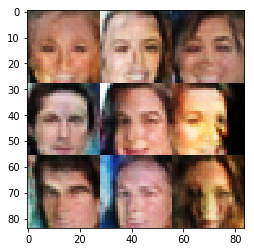

Step: 4310: Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 0.6136
Step: 4320: Epoch 1/1... Discriminator Loss: 1.3254... Generator Loss: 0.6533
Step: 4330: Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.5294
Step: 4340: Epoch 1/1... Discriminator Loss: 1.4667... Generator Loss: 0.7740
Step: 4350: Epoch 1/1... Discriminator Loss: 1.1257... Generator Loss: 1.0083
Step: 4360: Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.5046
Step: 4370: Epoch 1/1... Discriminator Loss: 1.6535... Generator Loss: 0.4087
Step: 4380: Epoch 1/1... Discriminator Loss: 1.3147... Generator Loss: 0.5629
Step: 4390: Epoch 1/1... Discriminator Loss: 1.3315... Generator Loss: 0.6949
Step: 4400: Epoch 1/1... Discriminator Loss: 1.2439... Generator Loss: 0.8599


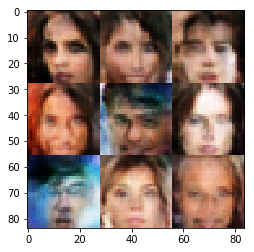

Step: 4410: Epoch 1/1... Discriminator Loss: 1.3326... Generator Loss: 0.5592
Step: 4420: Epoch 1/1... Discriminator Loss: 1.1611... Generator Loss: 0.8909
Step: 4430: Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 0.6810
Step: 4440: Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.5679
Step: 4450: Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.5661
Step: 4460: Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.7479
Step: 4470: Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 0.6780
Step: 4480: Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.9918
Step: 4490: Epoch 1/1... Discriminator Loss: 0.9961... Generator Loss: 1.1033
Step: 4500: Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 0.6970


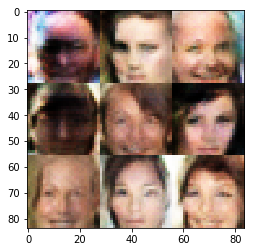

Step: 4510: Epoch 1/1... Discriminator Loss: 1.1368... Generator Loss: 1.0702
Step: 4520: Epoch 1/1... Discriminator Loss: 1.6482... Generator Loss: 0.3746
Step: 4530: Epoch 1/1... Discriminator Loss: 1.6244... Generator Loss: 0.3666
Step: 4540: Epoch 1/1... Discriminator Loss: 1.2320... Generator Loss: 0.9200
Step: 4550: Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.5610
Step: 4560: Epoch 1/1... Discriminator Loss: 1.3283... Generator Loss: 0.8072
Step: 4570: Epoch 1/1... Discriminator Loss: 1.5224... Generator Loss: 0.5041
Step: 4580: Epoch 1/1... Discriminator Loss: 1.2772... Generator Loss: 0.5705
Step: 4590: Epoch 1/1... Discriminator Loss: 1.2565... Generator Loss: 0.8292
Step: 4600: Epoch 1/1... Discriminator Loss: 1.2385... Generator Loss: 0.6897


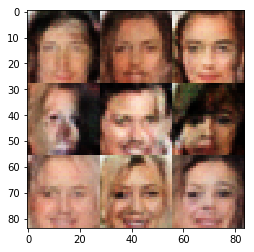

Step: 4610: Epoch 1/1... Discriminator Loss: 1.6737... Generator Loss: 0.3346
Step: 4620: Epoch 1/1... Discriminator Loss: 1.2952... Generator Loss: 1.1014
Step: 4630: Epoch 1/1... Discriminator Loss: 1.5440... Generator Loss: 0.4509
Step: 4640: Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 0.6926
Step: 4650: Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 0.6641
Step: 4660: Epoch 1/1... Discriminator Loss: 1.7477... Generator Loss: 0.3016
Step: 4670: Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.7093
Step: 4680: Epoch 1/1... Discriminator Loss: 1.1955... Generator Loss: 0.7667
Step: 4690: Epoch 1/1... Discriminator Loss: 1.8978... Generator Loss: 0.2734
Step: 4700: Epoch 1/1... Discriminator Loss: 1.6265... Generator Loss: 0.4929


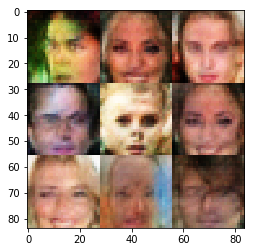

Step: 4710: Epoch 1/1... Discriminator Loss: 1.5113... Generator Loss: 0.7394
Step: 4720: Epoch 1/1... Discriminator Loss: 1.3429... Generator Loss: 0.5659
Step: 4730: Epoch 1/1... Discriminator Loss: 1.2911... Generator Loss: 0.8247
Step: 4740: Epoch 1/1... Discriminator Loss: 1.1705... Generator Loss: 1.1238
Step: 4750: Epoch 1/1... Discriminator Loss: 1.1977... Generator Loss: 0.8643
Step: 4760: Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 0.7777
Step: 4770: Epoch 1/1... Discriminator Loss: 1.6074... Generator Loss: 0.3913
Step: 4780: Epoch 1/1... Discriminator Loss: 1.1104... Generator Loss: 0.9391
Step: 4790: Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.8912
Step: 4800: Epoch 1/1... Discriminator Loss: 1.4794... Generator Loss: 0.4283


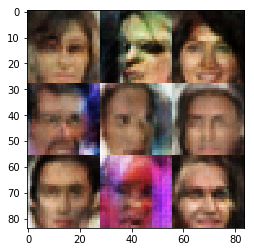

Step: 4810: Epoch 1/1... Discriminator Loss: 1.2057... Generator Loss: 0.8851
Step: 4820: Epoch 1/1... Discriminator Loss: 1.1983... Generator Loss: 0.9386
Step: 4830: Epoch 1/1... Discriminator Loss: 1.2793... Generator Loss: 0.8806
Step: 4840: Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 0.6678
Step: 4850: Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.5549
Step: 4860: Epoch 1/1... Discriminator Loss: 1.2477... Generator Loss: 0.8175
Step: 4870: Epoch 1/1... Discriminator Loss: 1.2550... Generator Loss: 0.8965
Step: 4880: Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.6018
Step: 4890: Epoch 1/1... Discriminator Loss: 1.4501... Generator Loss: 0.4669
Step: 4900: Epoch 1/1... Discriminator Loss: 1.6641... Generator Loss: 0.3654


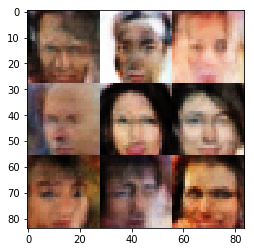

Step: 4910: Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 0.7037
Step: 4920: Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 0.8741
Step: 4930: Epoch 1/1... Discriminator Loss: 1.0913... Generator Loss: 0.8032
Step: 4940: Epoch 1/1... Discriminator Loss: 1.3350... Generator Loss: 0.6041
Step: 4950: Epoch 1/1... Discriminator Loss: 1.2166... Generator Loss: 0.7425
Step: 4960: Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.5306
Step: 4970: Epoch 1/1... Discriminator Loss: 1.1862... Generator Loss: 0.7886
Step: 4980: Epoch 1/1... Discriminator Loss: 1.1982... Generator Loss: 0.7369
Step: 4990: Epoch 1/1... Discriminator Loss: 1.6531... Generator Loss: 0.3768
Step: 5000: Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 0.6662


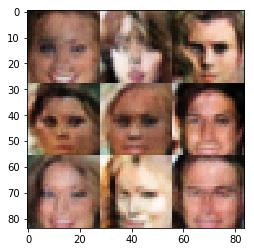

Step: 5010: Epoch 1/1... Discriminator Loss: 1.6758... Generator Loss: 0.3452
Step: 5020: Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 0.6112
Step: 5030: Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 1.2183
Step: 5040: Epoch 1/1... Discriminator Loss: 1.2439... Generator Loss: 0.9500
Step: 5050: Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 1.2783
Step: 5060: Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.7332
Step: 5070: Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.5327
Step: 5080: Epoch 1/1... Discriminator Loss: 1.1725... Generator Loss: 0.8673
Step: 5090: Epoch 1/1... Discriminator Loss: 1.2154... Generator Loss: 0.9627
Step: 5100: Epoch 1/1... Discriminator Loss: 1.1925... Generator Loss: 1.0902


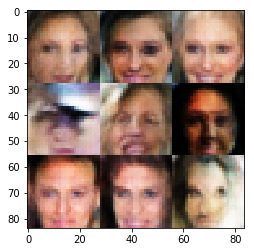

Step: 5110: Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 1.0643
Step: 5120: Epoch 1/1... Discriminator Loss: 1.1362... Generator Loss: 0.8208
Step: 5130: Epoch 1/1... Discriminator Loss: 1.2003... Generator Loss: 0.7763
Step: 5140: Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 0.7617
Step: 5150: Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 0.6659
Step: 5160: Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 0.5552
Step: 5170: Epoch 1/1... Discriminator Loss: 1.2610... Generator Loss: 0.8117
Step: 5180: Epoch 1/1... Discriminator Loss: 1.2649... Generator Loss: 0.6937
Step: 5190: Epoch 1/1... Discriminator Loss: 1.2945... Generator Loss: 0.8351
Step: 5200: Epoch 1/1... Discriminator Loss: 1.2167... Generator Loss: 0.9256


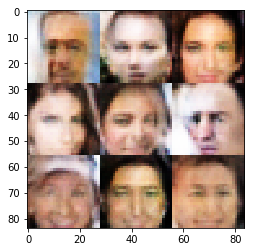

Step: 5210: Epoch 1/1... Discriminator Loss: 1.2232... Generator Loss: 0.9591
Step: 5220: Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.6766
Step: 5230: Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 0.6405
Step: 5240: Epoch 1/1... Discriminator Loss: 1.2595... Generator Loss: 0.9854
Step: 5250: Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.6330
Step: 5260: Epoch 1/1... Discriminator Loss: 1.1857... Generator Loss: 0.7609
Step: 5270: Epoch 1/1... Discriminator Loss: 1.1897... Generator Loss: 0.9488
Step: 5280: Epoch 1/1... Discriminator Loss: 1.1441... Generator Loss: 0.8681
Step: 5290: Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.5759
Step: 5300: Epoch 1/1... Discriminator Loss: 1.1792... Generator Loss: 0.9596


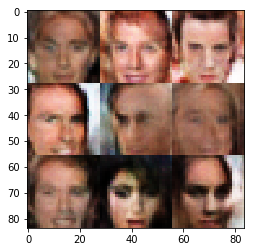

Step: 5310: Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.6284
Step: 5320: Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.7944
Step: 5330: Epoch 1/1... Discriminator Loss: 1.2047... Generator Loss: 0.7329
Step: 5340: Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 0.6360
Step: 5350: Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.7301
Step: 5360: Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.5542
Step: 5370: Epoch 1/1... Discriminator Loss: 1.5041... Generator Loss: 0.4512
Step: 5380: Epoch 1/1... Discriminator Loss: 1.2925... Generator Loss: 0.5751
Step: 5390: Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.5442
Step: 5400: Epoch 1/1... Discriminator Loss: 1.1124... Generator Loss: 0.7921


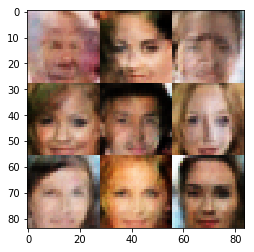

Step: 5410: Epoch 1/1... Discriminator Loss: 1.2545... Generator Loss: 0.7330
Step: 5420: Epoch 1/1... Discriminator Loss: 1.2244... Generator Loss: 1.2418
Step: 5430: Epoch 1/1... Discriminator Loss: 1.2721... Generator Loss: 1.0425
Step: 5440: Epoch 1/1... Discriminator Loss: 1.2813... Generator Loss: 0.9197
Step: 5450: Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.5962
Step: 5460: Epoch 1/1... Discriminator Loss: 1.2595... Generator Loss: 0.6778
Step: 5470: Epoch 1/1... Discriminator Loss: 1.3211... Generator Loss: 0.7897
Step: 5480: Epoch 1/1... Discriminator Loss: 1.5705... Generator Loss: 0.4005
Step: 5490: Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.4727
Step: 5500: Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 0.8218


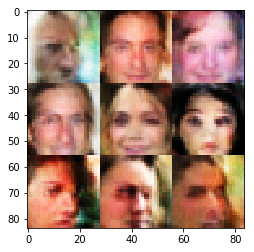

Step: 5510: Epoch 1/1... Discriminator Loss: 1.1275... Generator Loss: 1.1461
Step: 5520: Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.5491
Step: 5530: Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.6141
Step: 5540: Epoch 1/1... Discriminator Loss: 1.2006... Generator Loss: 0.8191
Step: 5550: Epoch 1/1... Discriminator Loss: 1.2979... Generator Loss: 0.8956
Step: 5560: Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.5505
Step: 5570: Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.6096
Step: 5580: Epoch 1/1... Discriminator Loss: 1.1606... Generator Loss: 1.2240
Step: 5590: Epoch 1/1... Discriminator Loss: 1.2639... Generator Loss: 0.7163
Step: 5600: Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.8240


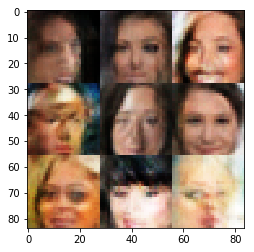

Step: 5610: Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.5612
Step: 5620: Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 0.8191
Step: 5630: Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.5587
Step: 5640: Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.5508
Step: 5650: Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 0.8776
Step: 5660: Epoch 1/1... Discriminator Loss: 1.1706... Generator Loss: 0.9774
Step: 5670: Epoch 1/1... Discriminator Loss: 1.2557... Generator Loss: 1.0816
Step: 5680: Epoch 1/1... Discriminator Loss: 1.2840... Generator Loss: 0.7286
Step: 5690: Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.7283
Step: 5700: Epoch 1/1... Discriminator Loss: 1.1960... Generator Loss: 0.7228


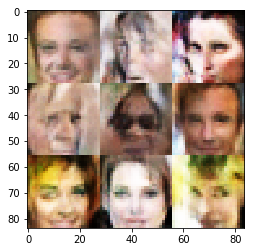

Step: 5710: Epoch 1/1... Discriminator Loss: 1.3408... Generator Loss: 0.5982
Step: 5720: Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 0.9192
Step: 5730: Epoch 1/1... Discriminator Loss: 1.1298... Generator Loss: 0.7669
Step: 5740: Epoch 1/1... Discriminator Loss: 1.5102... Generator Loss: 0.4755
Step: 5750: Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 0.7652
Step: 5760: Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.7641
Step: 5770: Epoch 1/1... Discriminator Loss: 1.2007... Generator Loss: 0.8803
Step: 5780: Epoch 1/1... Discriminator Loss: 1.1701... Generator Loss: 1.2241
Step: 5790: Epoch 1/1... Discriminator Loss: 1.2670... Generator Loss: 0.6861
Step: 5800: Epoch 1/1... Discriminator Loss: 1.1694... Generator Loss: 0.6982


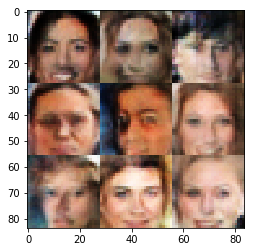

Step: 5810: Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 0.6393
Step: 5820: Epoch 1/1... Discriminator Loss: 1.5272... Generator Loss: 0.4722
Step: 5830: Epoch 1/1... Discriminator Loss: 1.2010... Generator Loss: 0.7642
Step: 5840: Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.6736
Step: 5850: Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 0.7381
Step: 5860: Epoch 1/1... Discriminator Loss: 1.1315... Generator Loss: 0.9402
Step: 5870: Epoch 1/1... Discriminator Loss: 1.1691... Generator Loss: 1.0532
Step: 5880: Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 0.5687
Step: 5890: Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.5471
Step: 5900: Epoch 1/1... Discriminator Loss: 1.1780... Generator Loss: 0.8233


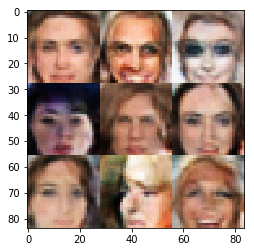

Step: 5910: Epoch 1/1... Discriminator Loss: 1.2295... Generator Loss: 0.8777
Step: 5920: Epoch 1/1... Discriminator Loss: 1.2792... Generator Loss: 0.6444
Step: 5930: Epoch 1/1... Discriminator Loss: 1.2741... Generator Loss: 0.8137
Step: 5940: Epoch 1/1... Discriminator Loss: 1.1359... Generator Loss: 0.8955
Step: 5950: Epoch 1/1... Discriminator Loss: 1.1119... Generator Loss: 0.8290
Step: 5960: Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 0.8414
Step: 5970: Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 0.6116
Step: 5980: Epoch 1/1... Discriminator Loss: 1.2135... Generator Loss: 0.8499
Step: 5990: Epoch 1/1... Discriminator Loss: 1.2970... Generator Loss: 0.6397
Step: 6000: Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.7053


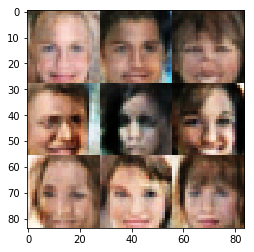

Step: 6010: Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 0.7475
Step: 6020: Epoch 1/1... Discriminator Loss: 1.1447... Generator Loss: 0.6763
Step: 6030: Epoch 1/1... Discriminator Loss: 1.2572... Generator Loss: 0.5526
Step: 6040: Epoch 1/1... Discriminator Loss: 1.2299... Generator Loss: 0.7855
Step: 6050: Epoch 1/1... Discriminator Loss: 1.1803... Generator Loss: 0.8506
Step: 6060: Epoch 1/1... Discriminator Loss: 1.3166... Generator Loss: 0.6652
Step: 6070: Epoch 1/1... Discriminator Loss: 1.5152... Generator Loss: 0.4589
Step: 6080: Epoch 1/1... Discriminator Loss: 1.0353... Generator Loss: 1.0663
Step: 6090: Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 0.4541
Step: 6100: Epoch 1/1... Discriminator Loss: 1.1402... Generator Loss: 0.9323


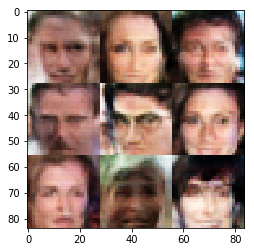

Step: 6110: Epoch 1/1... Discriminator Loss: 1.1825... Generator Loss: 1.0577
Step: 6120: Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 0.6116
Step: 6130: Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.6270
Step: 6140: Epoch 1/1... Discriminator Loss: 1.2609... Generator Loss: 0.6304
Step: 6150: Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 1.3460
Step: 6160: Epoch 1/1... Discriminator Loss: 1.2194... Generator Loss: 0.7822
Step: 6170: Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.9276
Step: 6180: Epoch 1/1... Discriminator Loss: 1.1231... Generator Loss: 0.7618
Step: 6190: Epoch 1/1... Discriminator Loss: 1.2432... Generator Loss: 0.8972
Step: 6200: Epoch 1/1... Discriminator Loss: 1.6464... Generator Loss: 0.3538


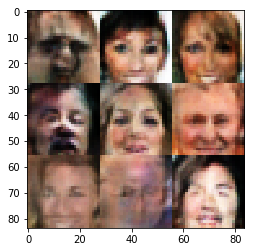

Step: 6210: Epoch 1/1... Discriminator Loss: 1.3530... Generator Loss: 0.5488
Step: 6220: Epoch 1/1... Discriminator Loss: 1.4974... Generator Loss: 0.4861
Step: 6230: Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 0.6878
Step: 6240: Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.5365
Step: 6250: Epoch 1/1... Discriminator Loss: 1.1548... Generator Loss: 0.7938
Step: 6260: Epoch 1/1... Discriminator Loss: 1.0439... Generator Loss: 1.1984
Step: 6270: Epoch 1/1... Discriminator Loss: 1.2159... Generator Loss: 0.6892
Step: 6280: Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 0.4294
Step: 6290: Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.6805
Step: 6300: Epoch 1/1... Discriminator Loss: 1.2934... Generator Loss: 0.8558


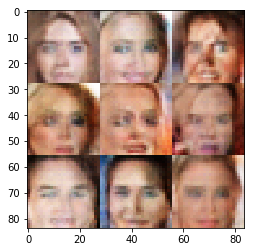

Step: 6310: Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 0.6186
Step: 6320: Epoch 1/1... Discriminator Loss: 1.2032... Generator Loss: 0.7177
Step: 6330: Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.6308
Training done!


In [38]:
batch_size = 32
z_dim = 128
learning_rate = 0.0012
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.